# Jupyter Notebook to Try and JIT My EGM

2/10/2025
Alexander Abajian
...
Script to generate expected value functions and conditional choice
probabilities using the discrete‐choice endogenous grid method of Iskhakov (2017)

Reference: https://onlinelibrary.wiley.com/doi/abs/10.3982/QE643



Packages

In [1]:
import numpy as np
import numba
from numba import jit

import os  # lets you set your working directory easily
import copy #use for shallow copies of value functions
import time  #use for timing code iterations
from scipy.io import loadmat
from scipy.interpolate import interp1d

# Set your working directory to save files into



# Read Matlab Files mat files that I need ((NB this is CHAT))

In [2]:
from distance_matrix_function import  distance_matrix_function


# Load baseline steady-state productivity levels.
# (Assumes the .mat file contains a variable named 'baseline_economy')
baseline_data = loadmat("baseline_economy.mat")
baseline_economy = baseline_data['baseline_economy']

# In MATLAB, indexing is 1-indexed. Here we use 0-indexing.
country_index = baseline_economy[:, 0].flatten()
population_share = baseline_economy[:, 2].flatten()  # MATLAB column 3
tfp_BL = baseline_economy[:, 3].flatten()              # MATLAB column 4


# Load bilateral (normalized) distances.
# (Assumes the .mat file contains a variable named 'distance_matrix')
distances_data = loadmat("distances.mat")
distance_matrix = distances_data['distance_matrix']

# prod grid testing
prod_grid = tfp_BL 
theta_hat = np.array([ 4,	4, 0.1,	0.1,
                      0.1	,0.1 , 0.1 ,
                      0.1,0.1,0.1,	0.3,	0.1	,1])
#theta_hat,prod_grid, distance_matrix


m_matrix_test = distance_matrix_function(theta_hat, distance_matrix, prod_grid)
wage_grid = prod_grid *(1-0.3)* (0.3/(0.0254+0.6))**(0.3/(1-0.3))



# Set up John Stachurski JIT'ed version remove r and migration matrix

In [3]:
import numba
import numpy as np
from numba import float64
from numba import int64
from numba.experimental import jitclass
# from numpy.polynomial.polynomial import polyfit, polyval
# from numpy import interp, ndarray, piecewise



dcegm_data = [
    ('α', float64),          # Production parameter
    ('β', float64),          # Discount factor
    ('δ', float64),          # Depreciation
    ('γ', float64),          # growth
    ('ν', float64),          # dispersion 
    ('r', float64),          # interest rate 
    ('grid_max', float64),    # max wealth
    ('grid_size', int64),
    ('number_locations',int64),
    ('prod_states',int64),
    ('asset_grid', float64[:]),    # asset grid (array)
    ('wage_grid', float64[:]),    # wage grid (array)
    ('prod_grid', float64[:]),    # wage grid (array)
    ('locations', float64[:]),    # locations array  (array)
    ('s_grid', float64[:]),    # productivity grid (array)
    ('pi_array', float64[:])    # productivity transitionsas array
]




@jitclass(dcegm_data)
class dcegm_model:

    def __init__(self,
                α=0.3,
                β=0.985,
                δ=0.06,
                γ=1.01,
                ν=0.5,
                r=0.01,
                s_grid=np.array([0.2, 1], dtype=np.float64),  
                prod_grid = np.zeros([154], dtype=np.float64),
                wage_grid = np.zeros([154], dtype=np.float64),
                pi_array=np.array([0.5, 0.5, 0.05, 0.95], dtype=np.float64), 
                grid_max=5,
                grid_size=101):

        

        ##params
        self.α, self.β, self.γ, self.δ, self.ν , self.r = α,β,γ,δ,ν,r
        

        ## grids i provide
        #set prod grid
        self.prod_grid = prod_grid

        
        self.wage_grid = prod_grid*(1-self.α)* ( self.α/(self.r+self.δ))**(self.α/(1-self.α))
        self.s_grid = s_grid
        self.pi_array = pi_array
        self.number_locations = len(prod_grid)
        self.prod_states = len(s_grid)
        
        # Set up asset grid
        self.grid_max = grid_max
        self.grid_size = grid_size
        self.asset_grid = np.linspace(0, grid_max, grid_size)

        # Set up location grid
        self.locations = np.linspace(1,self.number_locations,self.number_locations)

    def wealth_of_a(self,a,s,dest):
        "Wealth next period as function of xd"
        return (1+self.r)*a + self.s_grid[s]*self.wage_grid[dest]


    def u_c(self, c):
        "utility function"
        return np.log(c)
    
    def du_dc(self, c):
        "Derivative of utility"
        return 1/c

    def du_dc_inv(self, m_utility):
        "Inverse of m_utility'"
        return 1/m_utility
    
    
    def interp_exterp(self,input, xp, fp):
        """1D piecewise linear interpolation with linear extrapolation."""

    
    ## one direction
        if input > xp[-1]:
            output= xp[-1] +  (input - xp[-1])  * (fp[-1] - fp[-2])/(xp[-1] - xp[-2]) 
        else:
            output = np.interp(input, xp, fp)
            
        return output
    




# try an initialize an instance of my dcegm model class


In [4]:
prod_grid_short = prod_grid
prod_grid_short = np.array([0.1, 1])
#prod_grid_short = np.array([0.1, 1, 1, 1, 1, 1, 1, 1, 1])
dcegm_model_in = dcegm_model(r=0.01,prod_grid = prod_grid_short)
# dcegm_model_in = dcegm_model(r=20,wage_grid = [])




# Testing aiyagari simulating across all agents

In [5]:
import quantecon as qe 
from simulate_agents_parallel import simulate_agents_parallel
from simulate_parallel_EGM_parallel import simulate_parallel_EGM_parallel
from distance_matrix_function import  distance_matrix_function


model_in = dcegm_model_in
# Initialize parameters
β = model_in.β
r = model_in.r
γ = model_in.γ
ν = model_in.ν

## grids
wage_grid = model_in.wage_grid
s_grid = model_in.s_grid
prod_states=len(s_grid)
asset_grid = model_in.asset_grid
locations = model_in.locations
number_locations = model_in.number_locations 
prod_grid = tfp_BL 

## MIGRATION MATRIX

theta_hat = np.array([ 4,	4, 0.1,	0.1,
                      0.1	,0.1 , 0.1 ,
                      0.1,0.1,0.1,	0.3,	0.1	,1])
#theta_hat,prod_grid, distance_matrix
pi_matrix = np.array([ [model_in.pi_array[0],model_in.pi_array[1] ],[ model_in.pi_array[2],model_in.pi_array[3] ] ]) 
m_matrix = distance_matrix_function(theta_hat, distance_matrix, prod_grid)

##EGM startng valeus
grid_size = model_in.grid_size

#initialize stating values
c_egm_0= np.ones((grid_size + 1, number_locations * number_locations, prod_states))
## row for zeros to be used in interpolation
c_egm_0[0, :, :] = 0
m_nodes = np.concatenate(([0],  asset_grid + 0.01))
m_egm_0 = np.tile(m_nodes[:, None, None], (1, number_locations * number_locations, prod_states))

# Value function grids for location choices
v_egm_0 = np.zeros_like(c_egm_0)
ev_egm_0 = np.zeros((grid_size,number_locations,prod_states))
m_egm_0 = np.array(m_egm_0)
c_egm_in = np.array(c_egm_0)
v_egm_0 = np.array(v_egm_0)
ev_egm_0 = np.array(ev_egm_0)

# Initialize asset and location paths
number_states = len(s_grid)
number_agents = 1_000
number_steps = 1_000

# Seed initial assets and locations
seed_locations = np.random.randint(0, number_locations, size= number_agents)
seed_assets = np.ones_like(seed_locations)
#seed_shocks = np.random.rand(number_steps, number_agents)
asset_paths = np.vstack([seed_assets, np.zeros((number_steps, number_agents))])
location_paths = np.vstack([seed_locations, np.zeros((number_steps, number_agents), dtype=int)])
prod_states = len(s_grid)




# ## markov chain
# ### NB MARKOV CHAINS ARE PRINTED AS OUTCOMES IN ROWS-- ROW INDEXES AGENTS AND COLUMS "PERIODS"---
mc = qe.MarkovChain(pi_matrix)
print(m_egm_0.shape)


##Simulate
start = time.time()
short_markov = mc.simulate_indices(ts_length=1,  num_reps=number_agents)
labor_paths = np.zeros((number_steps+1,number_agents), dtype=int)
labor_paths[0,:] = np.transpose(short_markov)

test_solver =  simulate_agents_parallel(labor_paths,seed_assets,prod_states,
                    m_egm_0,c_egm_0,v_egm_0,ev_egm_0,
                    seed_locations,asset_paths,location_paths, number_agents, number_steps,model_in,m_matrix)
end = time.time()
print("Time elapsed: parallel, no mc argument", end - start)



# ##Simulate
start = time.time()
short_markov = mc.simulate_indices(ts_length=1,  num_reps=number_agents)
labor_paths = np.zeros((number_steps+1,number_agents), dtype=int)
labor_paths[0,:] = np.transpose(short_markov)

test_solver =  simulate_parallel_EGM_parallel(labor_paths,seed_assets,prod_states,
                    m_egm_0,c_egm_0,v_egm_0,ev_egm_0,
                    seed_locations,asset_paths,location_paths, number_agents, number_steps,model_in,m_matrix)
end = time.time()
print("Time elapsed: parallel, no mc argument,parallelized_VFI", end - start)

location_paths_out = test_solver[1]



(102, 81, 2)
Error at iteration 100 is <object type:float64>.
Error at iteration 200 is <object type:float64>.
Error at iteration 300 is <object type:float64>.
Error at iteration 400 is <object type:float64>.
Error at iteration 500 is <object type:float64>.
Error at iteration 600 is <object type:float64>.
Error at iteration 700 is <object type:float64>.
Error at iteration 800 is <object type:float64>.
Error at iteration 900 is <object type:float64>.
Error at iteration 1000 is <object type:float64>.
Error at iteration 1100 is <object type:float64>.
Error at iteration 1200 is <object type:float64>.
Error at iteration 1300 is <object type:float64>.
Error at iteration 1400 is <object type:float64>.
Error at iteration 1500 is <object type:float64>.

Converged in 1546 iterations.
Time elapsed: parallel, no mc argument 189.7774739265442


# Aiyagari simulation version that simulates all agents at once (simulate agents.py)

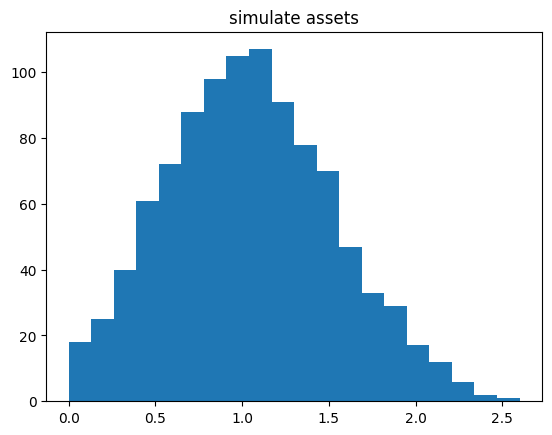

np.float64(1.0493341318843439)

(array([283., 325., 392.]),
 array([0.        , 2.66666667, 5.33333333, 8.        ]),
 <BarContainer object of 3 artists>)

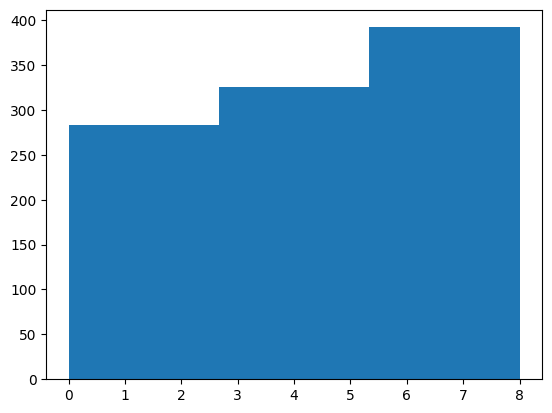

In [6]:
#print(seed_locations,location_paths_out)

import matplotlib.pyplot as plt
plt.hist(test_solver[0], bins='auto')  # arguments are passed to np.histogram
plt.title("simulate assets")
plt.show()

display(np.mean(test_solver[0]))

location_paths_out = test_solver[1]
plt.hist(location_paths_out, bins=3)
